<a href="https://colab.research.google.com/github/Pelus-o/Desafio-ifood/blob/main/Desafio_ifood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DecimalType, IntegerType
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

In [2]:
import requests
import gzip
import tarfile
import os
import logging

def download_and_extract(url, destination_folder="./data_source_ifood"):
    """
    Downloads a file from a URL, uncompresses it if it's a .gz or .tar.gz file,
    and saves it to a specified folder.
    Args:
        url (str): The URL of the file to download.
        destination_folder (str): The folder to save the downloaded and extracted file.
    """
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    local_filename = url.split('/')[-1]
    file_path = os.path.join(destination_folder, local_filename)

    # Download the file
    logging.info(f"Downloading {url} to {file_path}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        logging.info("Download complete.")
    # Check if the file is gzipped and unzip it
    if file_path.endswith('.gz'):
        logging.info(f"Uncompressing {file_path}...")
        if file_path.endswith('.tar.gz'):
            try:
                with tarfile.open(file_path, 'r:gz') as tar:
                    tar.extractall(path=destination_folder)
                logging.info("Extraction complete.")
            except tarfile.TarError as e:
                logging.error(f"Error extracting tar.gz file: {e}")
        else: # It's just a .gz file
            unzipped_file_path = file_path[:-3]  # Remove .gz extension
            try:
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_file_path, 'wb') as f_out:
                        f_out.writelines(f_in)
                logging.info("Uncompressing complete.")
            except gzip.BadGzipFile as e:
                 logging.error(f"Error uncompressing .gz file: {e}")

        return destination_folder # Return the destination folder where contents were extracted/unzipped
    else:
        logging.warning("File is not gzipped or a tar.gz.")
        return file_path

In [3]:
a= [
"https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
"https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
"https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz",
"https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"]

In [4]:
for i in a:
  download_and_extract(i)
  logging.info("Download and unzip complete.")

In [5]:
# Read the JSON file into a Spark DataFrame
df_order = spark.read.json("./data_source_ifood/order.json")
# Read the CSV file in Spark Dataframes
df_consumer = spark.read.csv("./data_source_ifood/consumer.csv", header=True, inferSchema=True)
df_restaurant = spark.read.csv("./data_source_ifood/restaurant.csv", header=True, inferSchema=True)
df_ab_test = spark.read.csv("./data_source_ifood/ab_test_ref.csv", header=True, inferSchema=True)

Clean null values in order_id columns, because not can be NULL

In [6]:
df_order = df_order.na.drop(subset=["order_id"])

Join entre as tabelas df_order e df_ab_test para saber quem comprou com ticket e sem ticket

In [7]:
df_order = df_order.join(df_ab_test, df_order.customer_id == df_ab_test.customer_id, "inner").select(df_order["*"], df_ab_test["is_target"])

# a- Indicator

- Sales rate indicator with and without ticket

In [8]:
total_orders = df_order.select("order_id").distinct().count()

target_orders = df_order.filter(F.col("is_target") == 'target').select("order_id").distinct().count()
control_orders = df_order.filter(F.col("is_target") == 'control').select("order_id").distinct().count()

# Calculate the percentage
percentage_target_orders = (target_orders / total_orders) * 100 if total_orders > 0 else 0
print(f"Percentage of order_id considered the 'target' etiquette: {percentage_target_orders:.2f}%")

percentage_control_orders = (control_orders / total_orders) * 100 if total_orders > 0 else 0
print(f"Percentage of order_id considered the 'control' etiquette: {percentage_control_orders:.2f}%")

Percentage of order_id considered the 'target' etiquette: 58.36%
Percentage of order_id considered the 'control' etiquette: 41.64%


# a- Indicator

- Percentage of 'target' sales over 'control' sales

In [11]:
target_order_sales = df_order.filter(F.col('is_target')=='target').select(F.sum('order_total_amount')).collect()[0][0]
control_order_sales = df_order.filter(F.col('is_target')=='control').select(F.sum('order_total_amount')).collect()[0][0]
Total_order_sales = df_order.select(F.sum('order_total_amount')).collect()[0][0]

# Calculate the sales money in the sales control and sales target

print(f"Target sales: {target_order_sales:.2f}")
print(f"Control sales: {control_order_sales:.2f}")

# percentage of money between the two target in the test A/B
print(f"Percentage of 'target' sales over 'control' sales: {(target_order_sales-control_order_sales)/Total_order_sales*100:.2f}")

Target sales: 102007569.84
Control sales: 73071872.88
Percentage of 'target' sales over 'control' sales: 16.53


In [23]:
df_order = df_order.withColumn("week_number", F.weekofyear(F.col("order_created_at")))
window_spec = Window.partitionBy("week_number").orderBy("order_created_at").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# The total sales and total order by week
df_order = df_order.withColumn("total_sales_by_week", F.sum("order_total_amount").over(window_spec)).withColumn("total_order_by_week", F.count("order_id").over(window_spec))
df_order_weekly_sum = df_order_weekly_sum.select(F.col("week_number"),F.col("total_sales_by_week"),F.col("total_order_by_week")).distinct()
df_order_weekly_sum.orderBy("week_number").show()

+-----------+--------------------+-------------------+
|week_number| total_sales_by_week|total_order_by_week|
+-----------+--------------------+-------------------+
|          1|  1.98234581400091E7|             423997|
|          2|2.7381824969967276E7|             567170|
|          3| 2.642493406997172E7|             559723|
|          4|2.6569450289973367E7|             559631|
|          5| 1.769472757001773E7|             356905|
|         49|1.2381910290012527E7|             264458|
|         50|1.6703623090022359E7|             338491|
|         51|1.3673816470014935E7|             289318|
|         52|1.4425697830016859E7|             302628|
+-----------+--------------------+-------------------+



# a - Indicator

- Weekly rate monitoring for product sales with and without a ticket

In [55]:
# The total sales by week and target
df_order_weekly_sum_target = df_order.groupBy(["week_number","is_target"]).agg(F.sum("order_total_amount").alias("total_sales_by_week_target"),F.count("order_id").alias("total_order_by_week_target"))

df_order_weekly_sum_target = df_order_weekly_sum_target.join(
    df_order_weekly_sum,
    df_order_weekly_sum_target.week_number == df_order_weekly_sum.week_number,
    "inner").select(df_order_weekly_sum_target["*"], df_order_weekly_sum["total_sales_by_week"], df_order_weekly_sum["total_order_by_week"])

df_order_weekly_sum_target = df_order_weekly_sum_target.withColumn(
    "percentage_sales_by_week_target", (F.col("total_sales_by_week_target")/F.col("total_sales_by_week")*100).cast(DecimalType(10,2))).withColumn(
    "percentage_order_by_week_target", (F.col("total_order_by_week_target")/F.col("total_order_by_week")*100).cast(DecimalType(10,2))).withColumn(
    "percentage_partial_order_by_week", (F.col("total_order_by_week_target")/total_orders*100).cast(DecimalType(10,2))).withColumn(
    "percentage_partial_sales_by_week", (F.col("total_sales_by_week_target")/Total_order_sales*100).cast(DecimalType(10,2))
    )

df_order_weekly_sum_target.select(
    "week_number",
    "is_target",
    "total_sales_by_week",
    "total_sales_by_week_target",
    "percentage_sales_by_week_target",
    "percentage_partial_sales_by_week",
    "total_order_by_week",
    "total_order_by_week_target",
    "percentage_order_by_week_target",
    "percentage_partial_order_by_week"
    ).orderBy("week_number").show()

+-----------+---------+--------------------+--------------------------+-------------------------------+--------------------------------+-------------------+--------------------------+-------------------------------+--------------------------------+
|week_number|is_target| total_sales_by_week|total_sales_by_week_target|percentage_sales_by_week_target|percentage_partial_sales_by_week|total_order_by_week|total_order_by_week_target|percentage_order_by_week_target|percentage_partial_order_by_week|
+-----------+---------+--------------------+--------------------------+-------------------------------+--------------------------------+-------------------+--------------------------+-------------------------------+--------------------------------+
|          1|   target|  1.98234581400091E7|      1.1537062760000153E7|                          58.20|                            6.59|             423997|                    247526|                          58.38|                           10.20|
|   

In [53]:
df_order_weekly_sum_target_pandas = df_order_weekly_sum_target.toPandas()

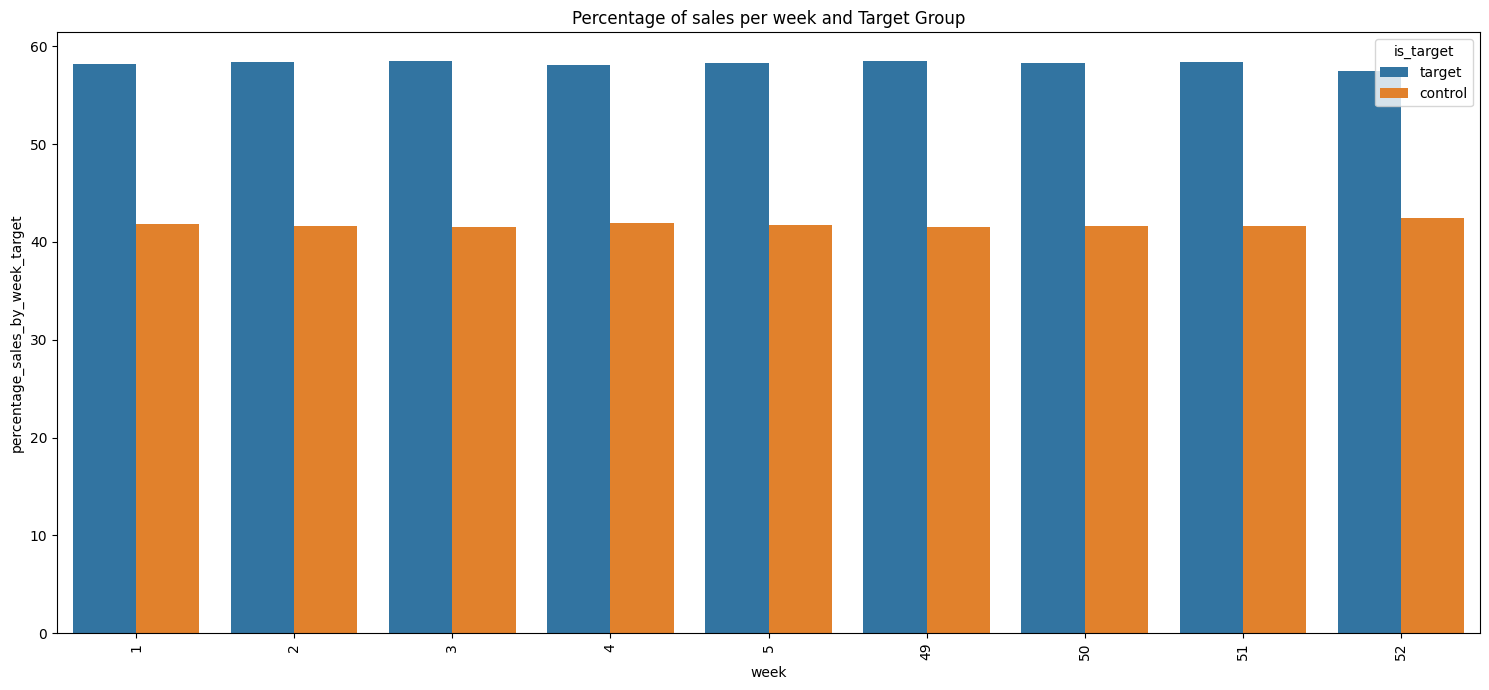

In [61]:
# Create a bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='week_number', y='percentage_sales_by_week_target', hue='is_target', data=df_order_weekly_sum_target_pandas)
plt.title('Percentage of sales per week and Target Group')
plt.xlabel('week')
plt.ylabel('percentage_sales_by_week_target')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

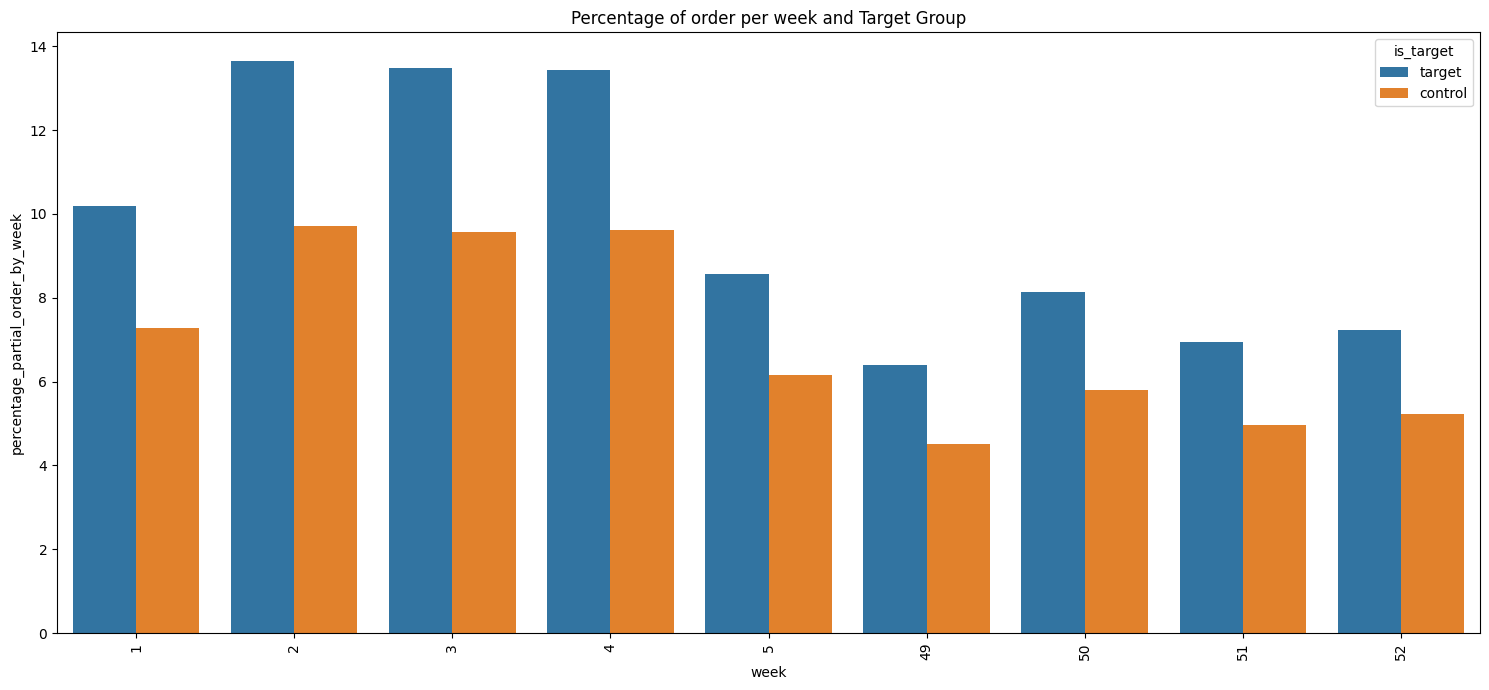

In [62]:
# Create a bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='week_number', y='percentage_partial_order_by_week', hue='is_target', data=df_order_weekly_sum_target_pandas)
plt.title('Percentage of order per week and Target Group')
plt.xlabel('week')
plt.ylabel('percentage_partial_order_by_week')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# a- Indicator

- User's repurchase fee monitoring
- Weekly monitoring of users' repurchase rate

In [30]:
# Calculate the number of resales for each target
resales_by_target = df_order.groupBy("is_target", "customer_id").agg(F.count("order_id").alias("order_count"))
resales_by_target = resales_by_target.filter(F.col("order_count") > 1).groupBy("is_target").count()
resales_by_target = resales_by_target.withColumn('percentage_resales_target', (F.col('count')/total_orders*100).cast(DecimalType(10,2)))

print("Number of resales by target:")
resales_by_target.show()
# Calculate the number of resales for each week
resales_by_week = df_order.groupBy("week_number", "is_target" ,"customer_id").agg(F.count("order_id").alias("order_count"))
resales_by_week_resales = resales_by_week.filter(F.col("order_count") > 1).groupBy("week_number","is_target").count().orderBy("week_number")
resales_by_week_resales = resales_by_week_resales.withColumn('percentage_resales_wee_target', (F.col('count')/total_orders*100).cast(DecimalType(10,2)))

print("Number of resales by week and target:")
resales_by_week_resales.orderBy(F.desc("week_number")).show()

Number of resales by target:
+---------+------+-------------------------+
|is_target| count|percentage_resales_target|
+---------+------+-------------------------+
|  control|269341|                    11.10|
|   target|354538|                    14.61|
+---------+------+-------------------------+

Number of resales by week and target:
+-----------+---------+-----+-----------------------------+
|week_number|is_target|count|percentage_resales_wee_target|
+-----------+---------+-----+-----------------------------+
|         52|   target|32441|                         1.34|
|         52|  control|22005|                         0.91|
|         51|  control|20840|                         0.86|
|         51|   target|31075|                         1.28|
|         50|   target|37653|                         1.55|
|         50|  control|25346|                         1.04|
|         49|   target|28373|                         1.17|
|         49|  control|18828|                         0.78|
| 

In [14]:
df_order_all = df_order.join(df_restaurant, df_order.merchant_id == df_restaurant.id, "inner").select(df_order["*"], df_restaurant["*"])

In [17]:
df_order_restaurant = df_order_all.groupBy("week_number","delivery_address_country","delivery_address_state","delivery_address_city","delivery_address_district",'is_target').agg(F.count("order_id").alias("order_count"),(F.sum("order_total_amount").cast(DecimalType(18,2)).alias("total_sales")),(F.avg("order_total_amount").cast(DecimalType(18,2)).alias("average_order_value")),(F.avg("delivery_time").cast(DecimalType(18,2)).alias("average_delivery_time")), (F.avg("price_range").cast(DecimalType(18,2)).alias("average_price_range")), (F.avg("minimum_order_value").cast(DecimalType(18,2)).alias("average_minimum_order_value")), (F.avg("average_ticket").cast(DecimalType(18,2)).alias("average_ticket")))
df_order_restaurant.orderBy("week_number").show()

+-----------+------------------------+----------------------+---------------------+-------------------------+---------+-----------+-----------+-------------------+---------------------+-------------------+---------------------------+--------------+
|week_number|delivery_address_country|delivery_address_state|delivery_address_city|delivery_address_district|is_target|order_count|total_sales|average_order_value|average_delivery_time|average_price_range|average_minimum_order_value|average_ticket|
+-----------+------------------------+----------------------+---------------------+-------------------------+---------+-----------+-----------+-------------------+---------------------+-------------------+---------------------------+--------------+
|         50|                      BR|                    PB|          JOAO PESSOA|                AEROCLUBE|   target|        133|    5230.57|              39.33|                22.78|               2.24|                       8.10|         46.77|
|   

In [39]:
df_order_restaurant_pandas = df_order_restaurant.toPandas()

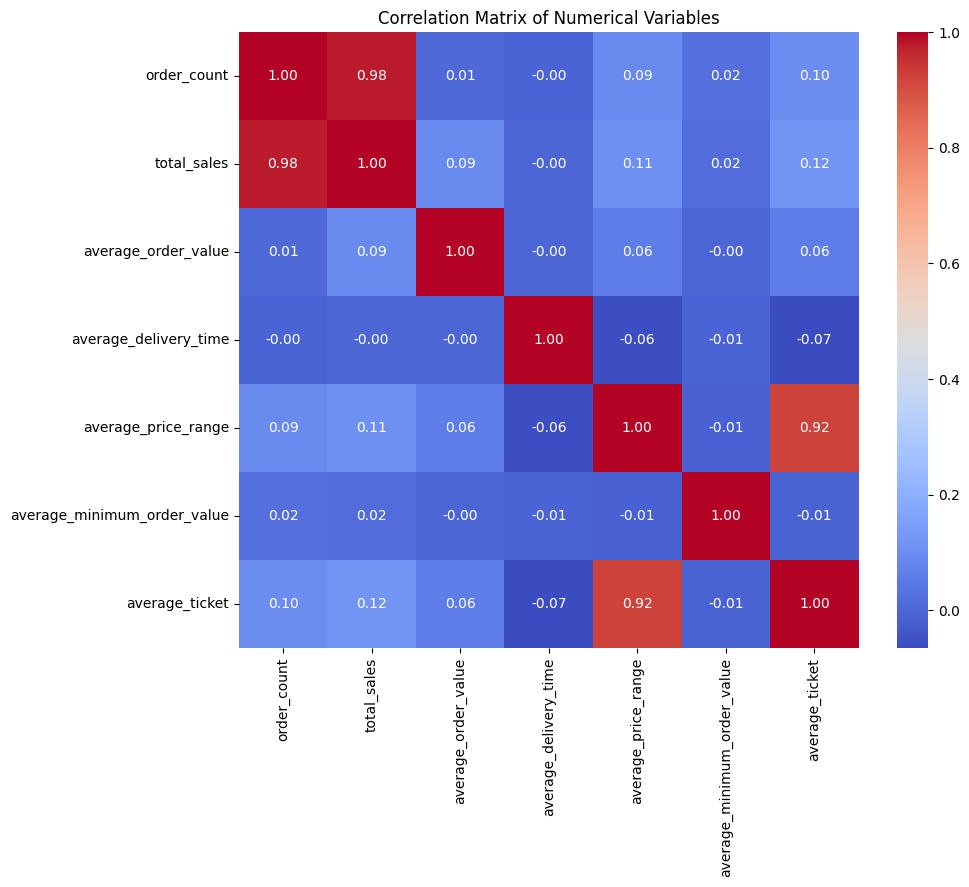

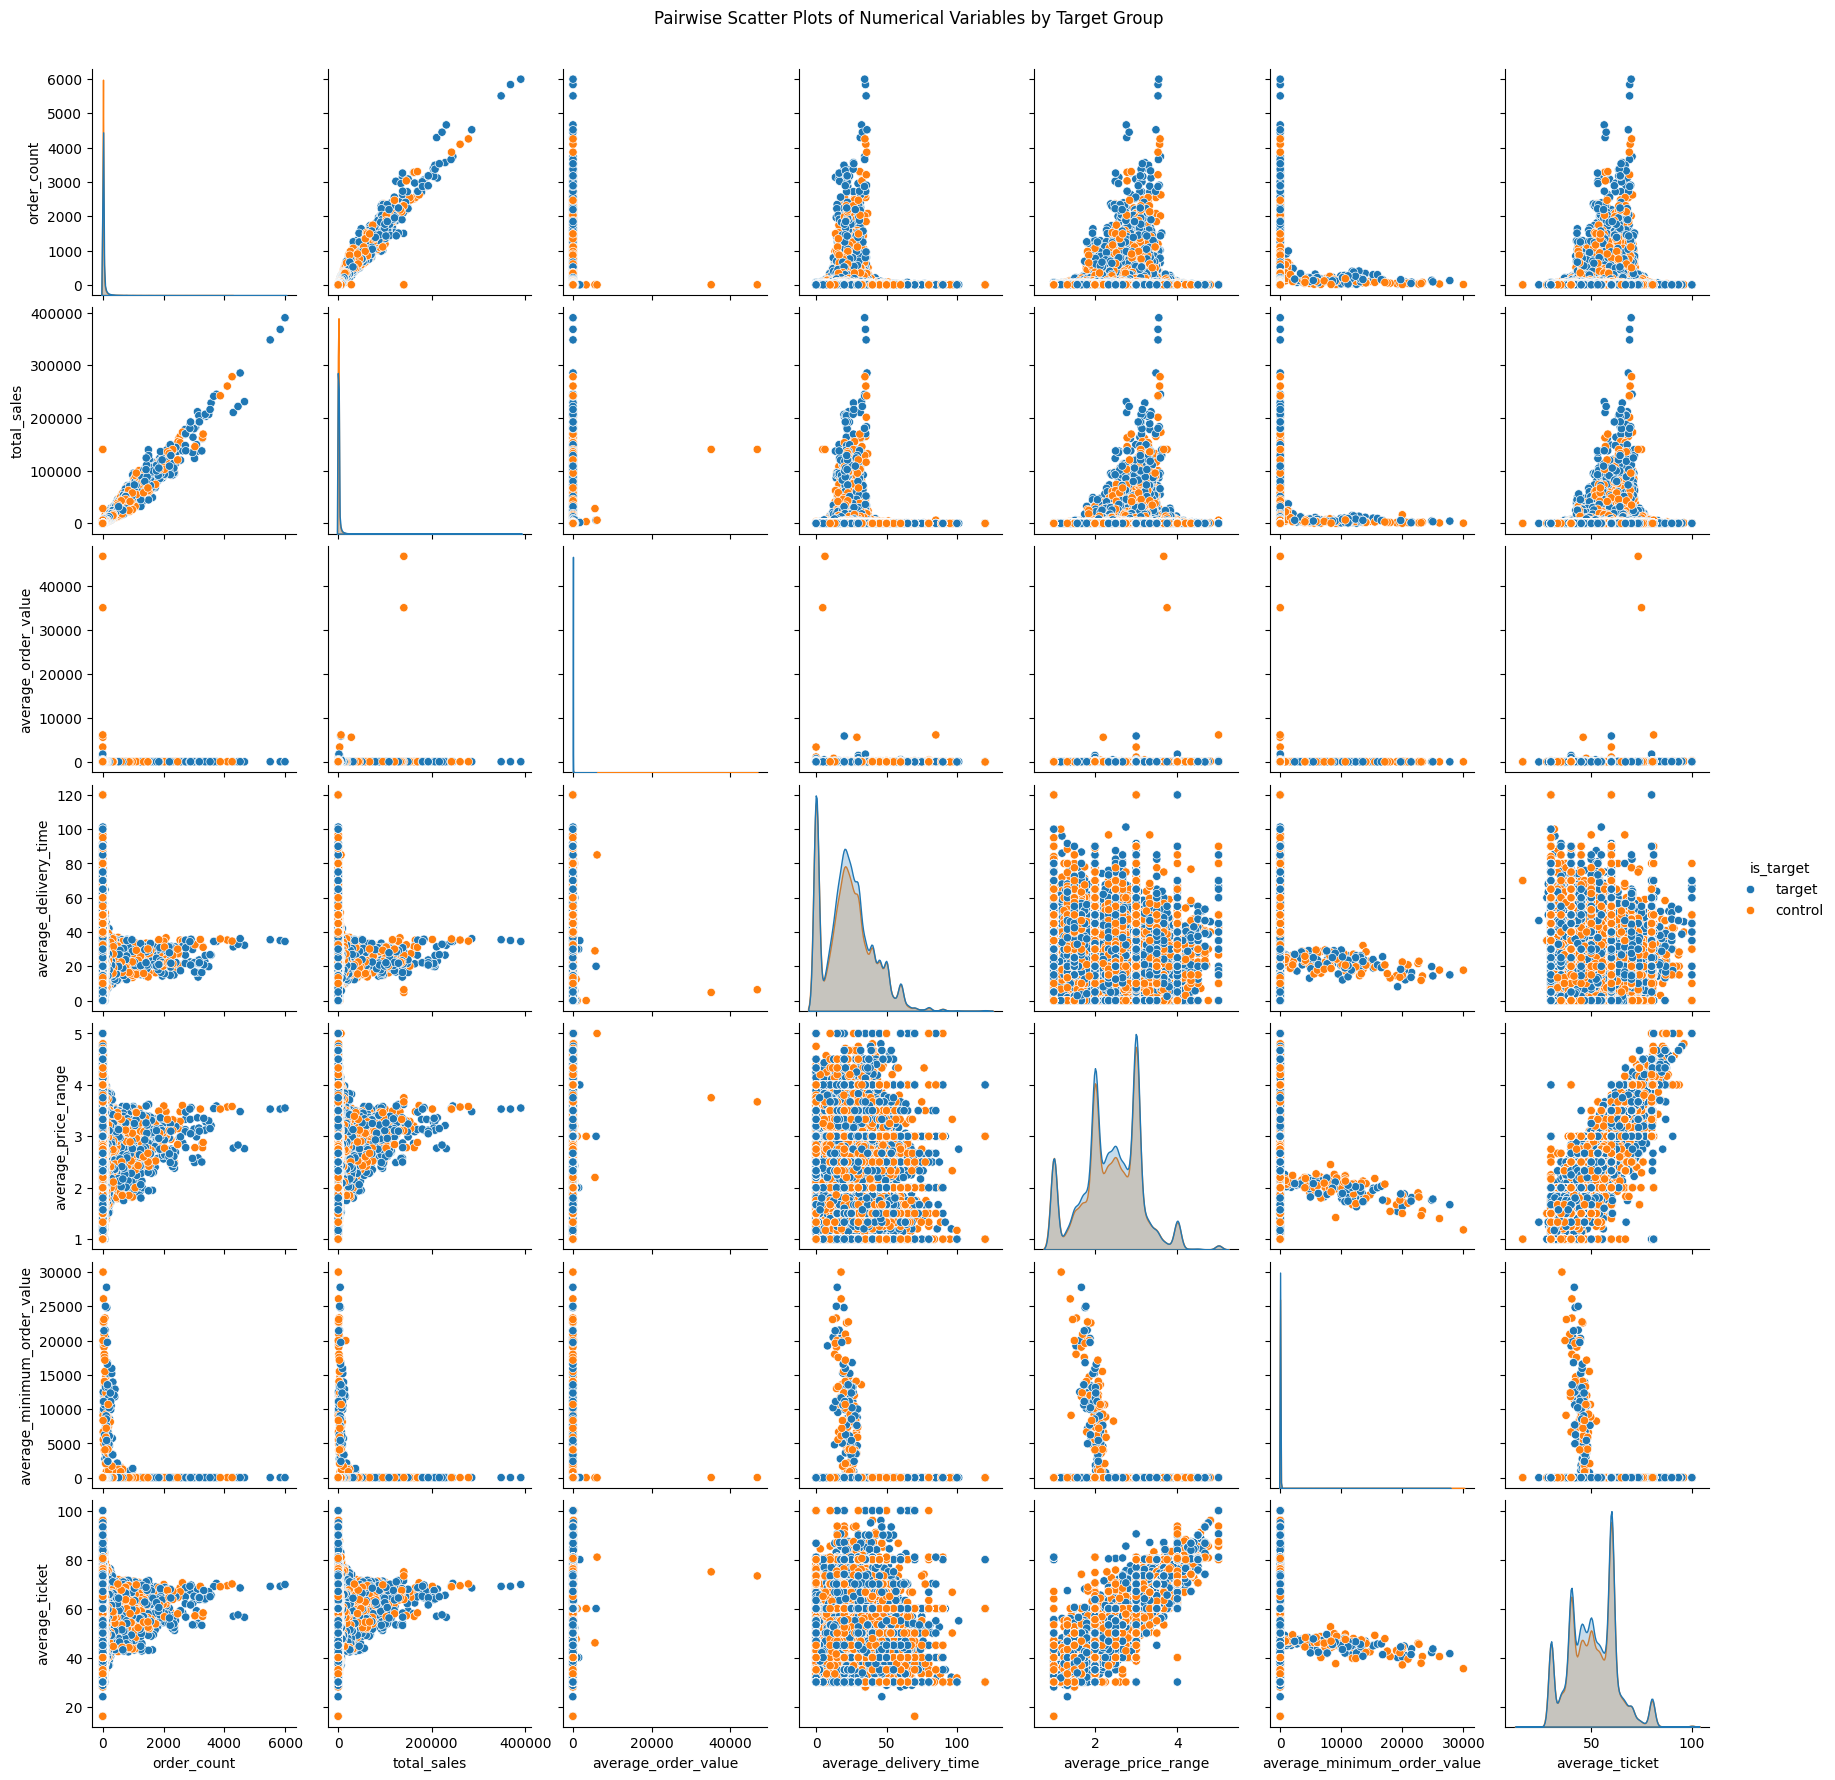

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns for correlation analysis
numerical_cols = ['order_count', 'total_sales', 'average_order_value',
                  'average_delivery_time', 'average_price_range',
                  'average_minimum_order_value', 'average_ticket']

# Calculate the correlation matrix
correlation_matrix = df_order_restaurant_pandas[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Create pairwise scatter plots of numerical variables
#sns.pairplot(df_order_restaurant_pandas, vars=numerical_cols, hue='is_target', diag_kind='kde')
#plt.suptitle('Pairwise Scatter Plots of Numerical Variables by Target Group', y=1.02)
#plt.show()


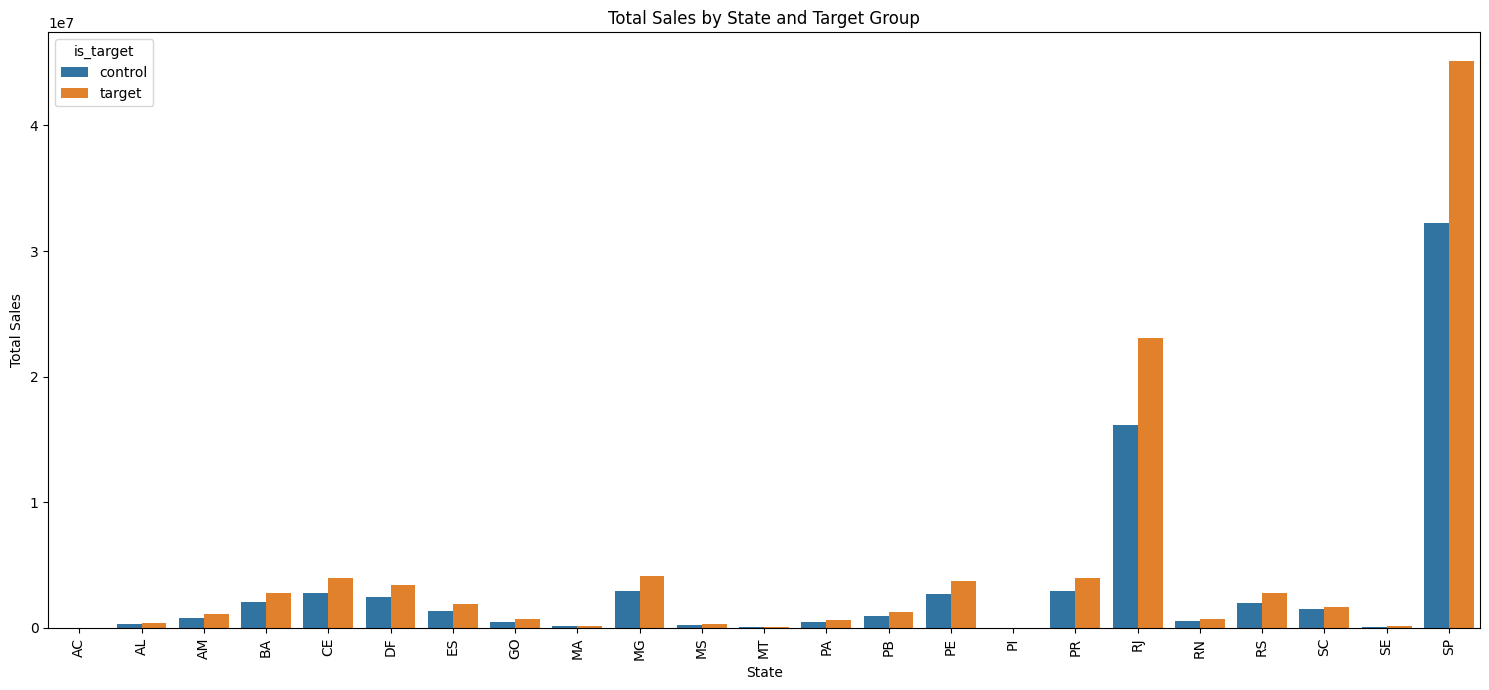

In [40]:
# Group by state and is_target, summing the total_sales
df_grouped = df_order_restaurant_pandas.groupby(['delivery_address_state', 'is_target'])['total_sales'].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='delivery_address_state', y='total_sales', hue='is_target', data=df_grouped)
plt.title('Total Sales by State and Target Group')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# for target_group in df_grouped['is_target'].unique():
#     plt.figure(figsize=(15, 7))
#     sns.barplot(x='delivery_address_state', y='total_sales', data=df_grouped[df_grouped['is_target'] == target_group])
#     plt.title(f'Total Sales by State for {target_group} Group')
#     plt.xlabel('State')
#     plt.ylabel('Total Sales')
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.show()


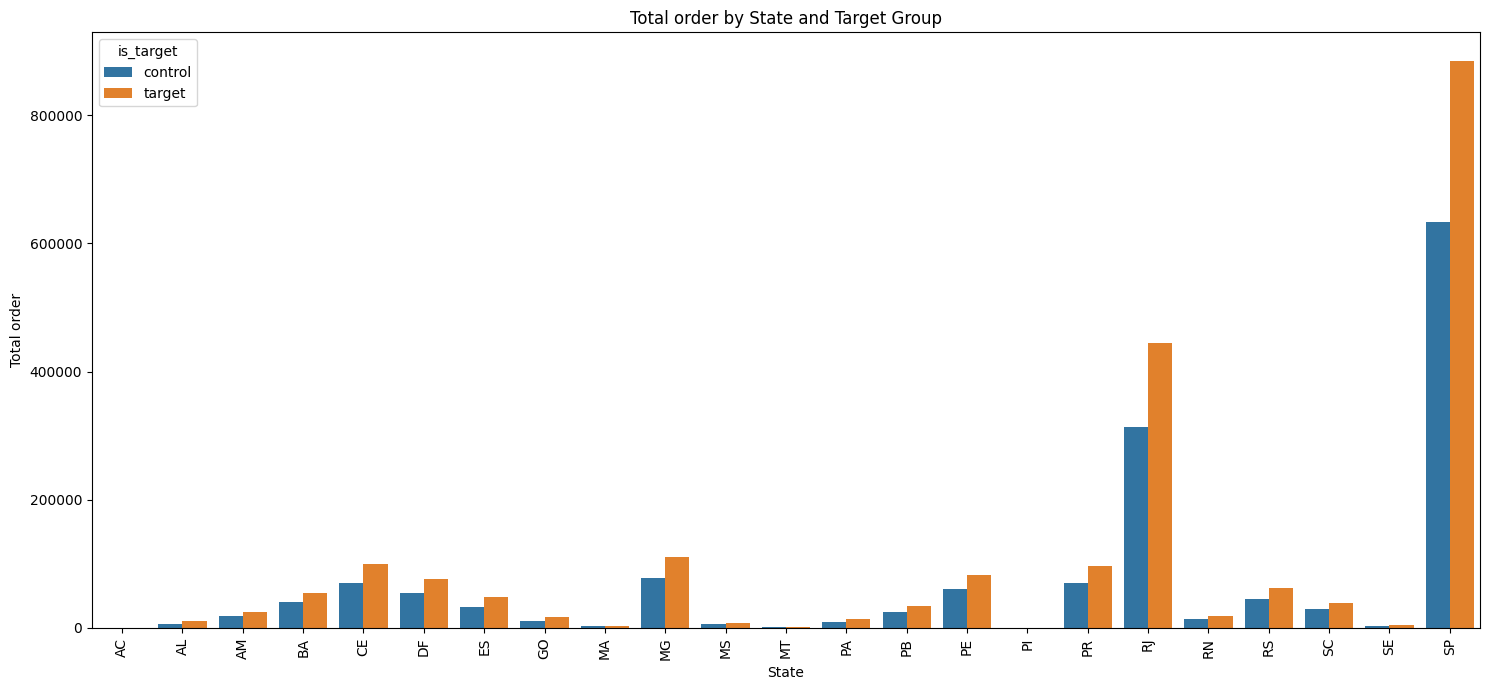

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by state and is_target, summing the total_sales
df_grouped = df_order_restaurant_pandas.groupby(['delivery_address_state', 'is_target'])['order_count'].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='delivery_address_state', y='order_count', hue='is_target', data=df_grouped)
plt.title('Total order by State and Target Group')
plt.xlabel('State')
plt.ylabel('Total order')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

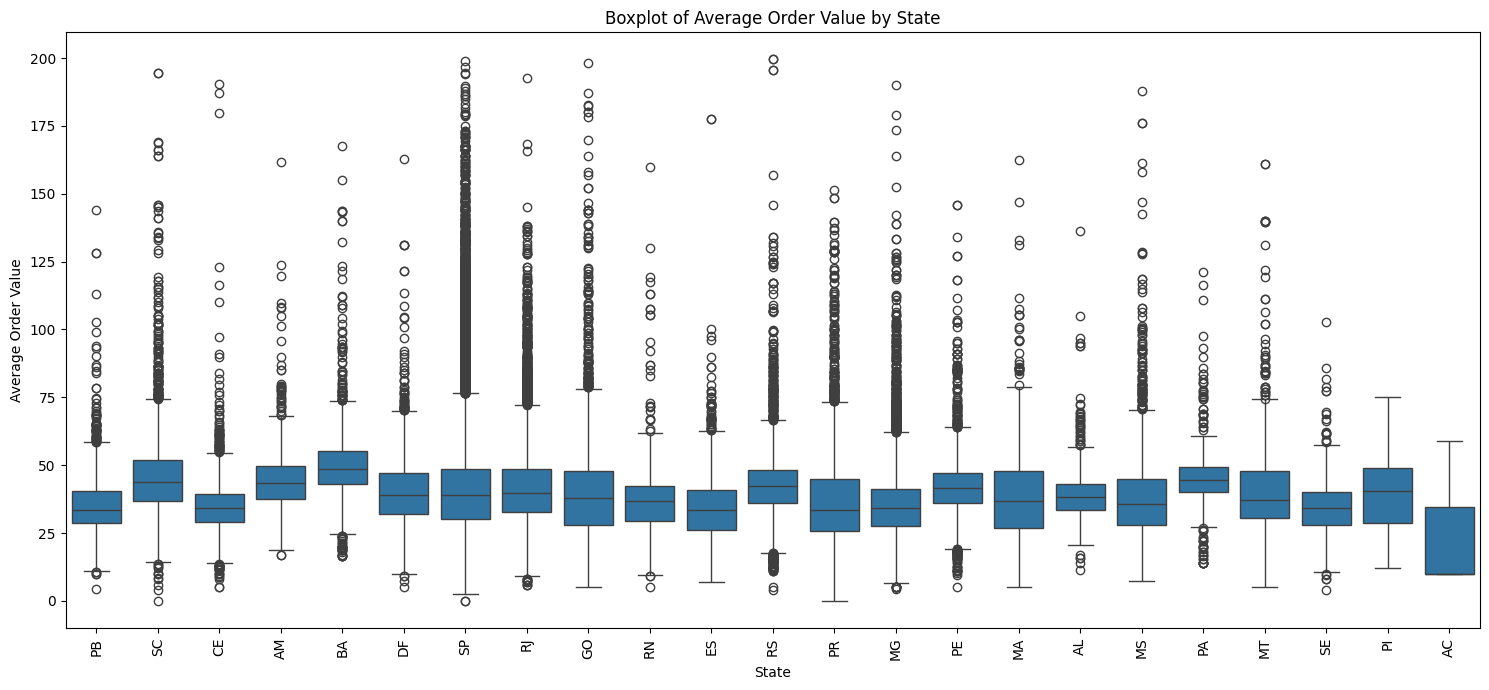

In [67]:
# Create a boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(x='delivery_address_state', y='average_order_value', data=df_order_restaurant_pandas[df_order_restaurant_pandas['average_order_value']<200])
plt.title('Boxplot of Average Order Value by State')
plt.xlabel('State')
plt.ylabel('Average Order Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [64]:
# Group by state and is_target, summing the total_sales
#df_grouped = df_order_restaurant_pandas.groupby(['delivery_address_city', 'is_target'])['order_count'].sum().reset_index()

# Create a bar plot
#plt.figure(figsize=(15, 7))
#sns.barplot(x='delivery_address_city', y='order_count', hue='is_target', data=df_grouped)
#plt.title('Total order by city and Target Group')
#plt.xlabel('City')
#plt.ylabel('Total order')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()

# 2-segmentation analises for users.

It is define a segmentation for the user considered the frequency of order.

In [44]:
# Calculate the number of orders per customer
df_customer_order_count = df_order.groupBy("customer_id").agg(F.count("order_id").alias("order_count"))

# Define frequency segments
# You can adjust these thresholds based on your data distribution
def categorize_frequency(order_count):
    if order_count == 1:
        return "One-time"
    elif order_count <= 5:
        return "Occasional"
    else:
        return "Frequent"

categorize_frequency_udf = F.udf(categorize_frequency)

df_customer_frequency = df_customer_order_count.withColumn(
    "frequency_segment", categorize_frequency_udf(F.col("order_count"))
)

print("Customer frequency distribution:")
df_customer_frequency.groupBy("frequency_segment").count().show()

# To analyze sales/orders by frequency segment and target group
df_order_with_frequency = df_order.join(df_customer_frequency, "customer_id", "left")

print("Sales and orders by frequency segment and target group:")
df_order_with_frequency.groupBy("frequency_segment", "is_target").agg(
    F.count("order_id").alias("total_orders"),
    F.sum("order_total_amount").cast(DecimalType(18,2)).alias("total_sales"),
    F.avg("order_total_amount").cast(DecimalType(18,2)).alias("average_order_value")
).orderBy("frequency_segment", "is_target").show()



Customer frequency distribution:
+-----------------+------+
|frequency_segment| count|
+-----------------+------+
|         One-time|182587|
|         Frequent|192963|
|       Occasional|430916|
+-----------------+------+

Sales and orders by frequency segment and target group:
+-----------------+---------+------------+-----------+-------------------+
|frequency_segment|is_target|total_orders|total_sales|average_order_value|
+-----------------+---------+------------+-----------+-------------------+
|         Frequent|  control|      910969|43418048.12|              47.66|
|         Frequent|   target|     1356031|64637824.06|              47.67|
|       Occasional|  control|      523406|25268786.43|              48.28|
|       Occasional|   target|      689328|32978635.43|              47.84|
|         One-time|  control|       91201| 4385038.33|              48.08|
|         One-time|   target|       91386| 4391110.35|              48.05|
+-----------------+---------+------------+----

In [47]:
print("Sales and orders by frequency segment target group, and week:")
df_order_with_frequency.groupBy("week_number","frequency_segment", "is_target").agg(
    F.count("order_id").alias("total_orders"),
    F.sum("order_total_amount").cast(DecimalType(18,2)).alias("total_sales"),
    F.avg("order_total_amount").cast(DecimalType(18,2)).alias("average_order_value")
).orderBy("frequency_segment", "is_target").orderBy("week_number").show()

Sales and orders by frequency segment target group, and week:
+-----------+-----------------+---------+------------+-----------+-------------------+
|week_number|frequency_segment|is_target|total_orders|total_sales|average_order_value|
+-----------+-----------------+---------+------------+-----------+-------------------+
|          1|         Frequent|  control|      100984| 4708774.48|              46.63|
|         50|         Frequent|  control|       85394| 4233721.55|              49.58|
|          4|         Frequent|  control|      139758| 6558138.89|              46.92|
|         52|         Frequent|  control|       77791| 3651716.16|              46.94|
|          5|         Frequent|  control|       83732| 4171691.02|              49.82|
|         49|         Frequent|  control|       70296| 3288603.11|              46.78|
|          2|         Frequent|  control|      136272| 6617941.22|              48.56|
|          3|         Frequent|  control|      139882| 6585506.42|  

In [48]:
df_order_with_frequency_pandas = df_order_with_frequency.groupBy("week_number","frequency_segment", "is_target").agg(
    F.count("order_id").alias("total_orders"),
    F.sum("order_total_amount").cast(DecimalType(18,2)).alias("total_sales"),
    F.avg("order_total_amount").cast(DecimalType(18,2)).alias("average_order_value")
).orderBy("frequency_segment", "is_target").toPandas()

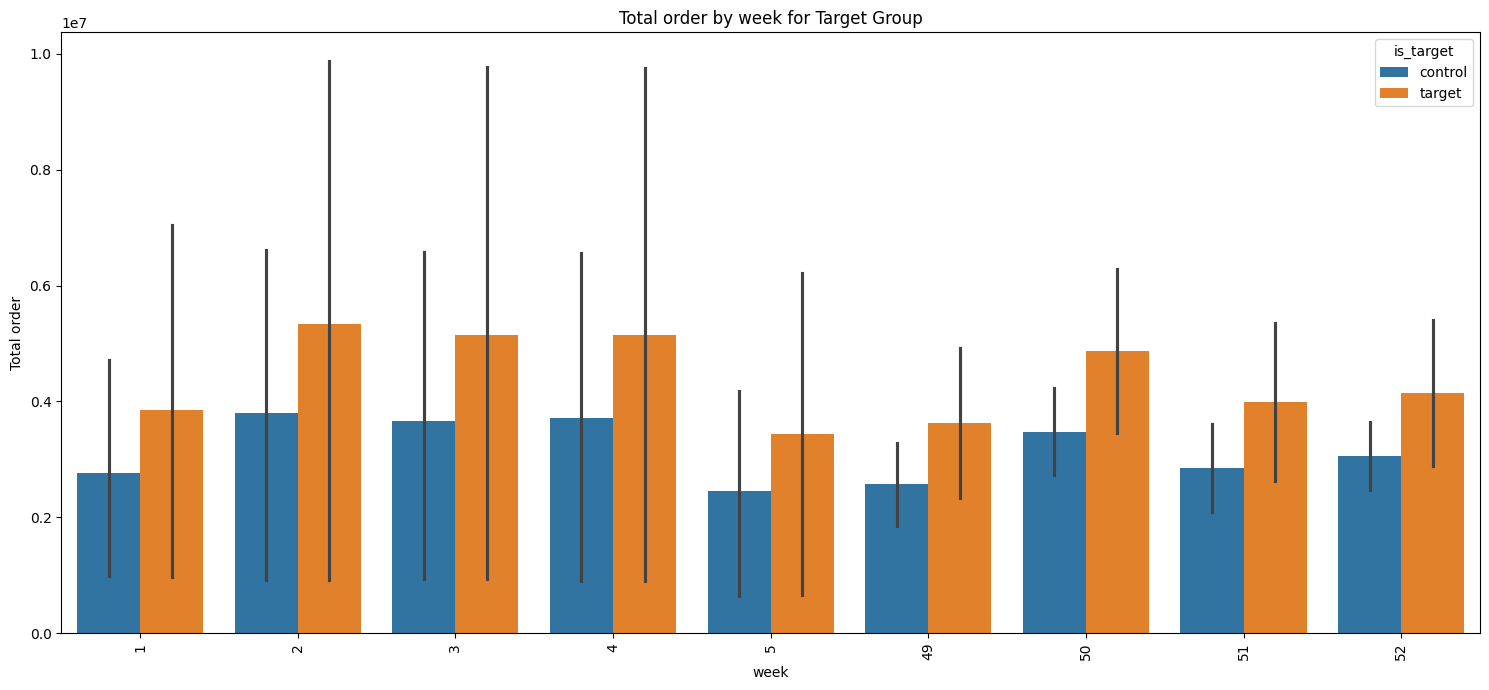

In [56]:
# Create a bar plot for Target Group
plt.figure(figsize=(15, 7))
sns.barplot(x='week_number', y='total_sales', hue='is_target', data=df_order_with_frequency_pandas)
plt.title('Total order by week for Target Group')
plt.xlabel('week')
plt.ylabel('Total order')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

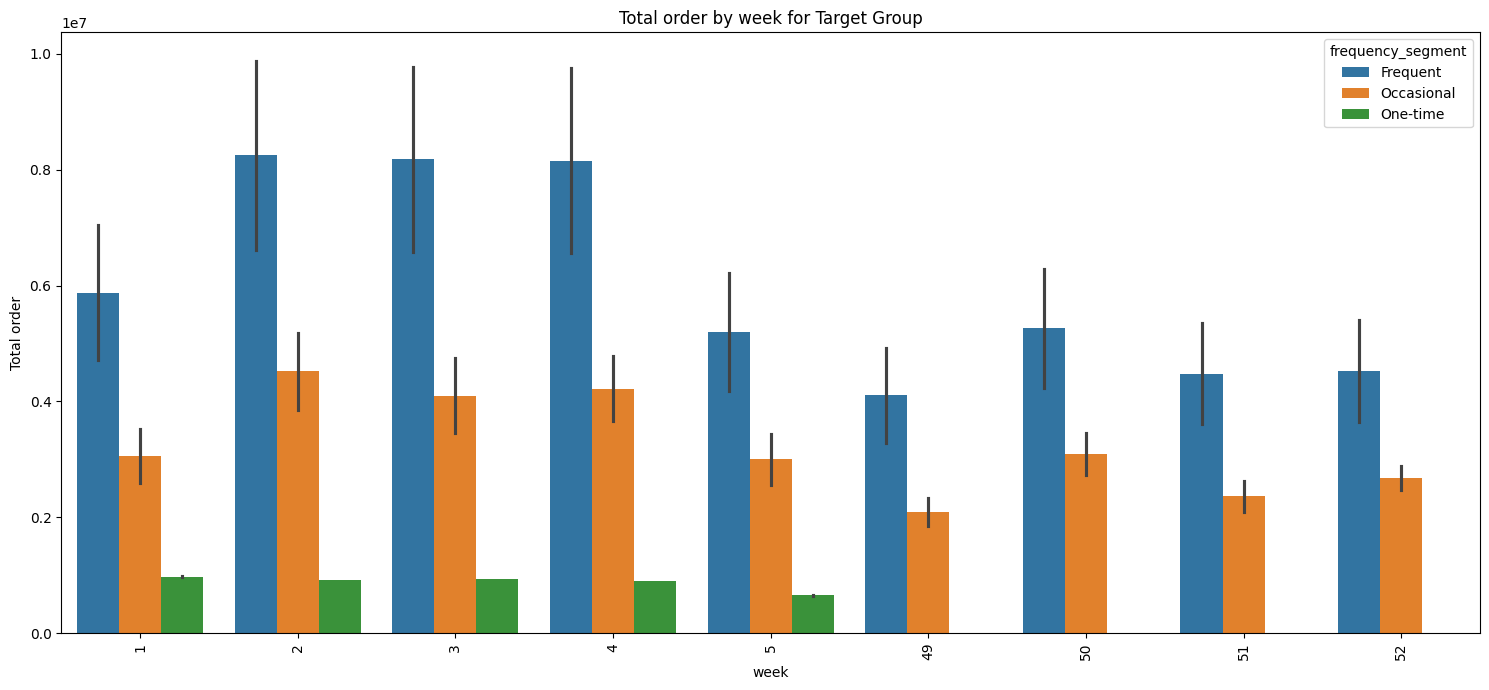

In [57]:
# Create a bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='week_number', y='total_sales', hue='frequency_segment', data=df_order_with_frequency_pandas)
plt.title('Total order by week for Target Group')
plt.xlabel('week')
plt.ylabel('Total order')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType, DoubleType

# Define the schema for the items array
#items_schema = ArrayType(StructType([
#    StructField("item_id", StringType(), True),
#    StructField("name", StringType(), True),
#    StructField("quantity", IntegerType(), True),
#    StructField("price", DoubleType(), True)
#]))

# Parse the JSON string in 'items' column and then explode it
#df_order = df_order.withColumn("items_parsed", F.from_json(F.col("items"), items_schema)) \
#                   .withColumn("items_struct", F.explode(F.col("items_parsed")))